# Project 1: Trump, Twitter, and Text

Welcome to the first project of DS100! In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project checkpoint is due 11:59pm Tuesday, Sept. 26.** The checkpoint is graded on *completeness*, not correctness. You must complete Questions 1-4 in order to get full credit for the checkpoint.

**The entire project is due 11:59pm Tuesday, Oct 3.**

*Fair warning:* This project involves significantly more challenging pandas operations than the previous homeworks. We strongly suggest you start early.

**Grading:**

The checkpoint is worth **10%** of the overall project grade and is graded on completeness.

However, the final submission of the project will be graded on **correctness**.

**Fun:**

We intended this project to be fun! You will analyze actual data from the Twitter API — no precooked dataset this time around. You will also draw conclusions about the current (and often controversial) US President's tweet behavior. If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

With that in mind, let's get started!

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

from IPython.display import display, Latex, Markdown
from client.api.notebook import Notebook
ok = Notebook('proj1.ok')

Assignment: Project 1
OK, version v1.13.4



In [3]:
# Log into OkPy. You may have to change this to ok.auth(force=True) if you run into
# an OAuthError
ok.auth(force=True)


Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: BlQMZYEr7FUHWFGm7VdRuEry11nJRv
Successfully logged in as leonrafael29@berkeley.edu


## <br/><br/><br/>

# Getting the dataset

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

#### Setup
Install `tweepy`, if you don't already have it.  (Be sure to activate your Conda environment for the class first.  Then run `pip install tweepy`.)

In [ ]:
## Make sure you are in your ds100 conda environment.
## Uncomment the following line to install tweepy
# !pip install tweepy

In [4]:
# The following should run
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

---
<br/><br/>

## Question 1

Follow the instructions below to get your Twitter API keys.  Read the instructions completely before starting.

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  Don't turn in that file.


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of your instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [5]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [6]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: leonrafael29


---
<br/><br/>


## Question 2

In the example below, we have loaded some tweets by @BerkeleyData.  Run it and read the code.

In [7]:
from pathlib import Path

ds_tweets_save_path = "BerkeleyData_recent_tweets.pkl"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Obtaining twitter keys
    import json
    key_file = 'keys.json'
    # Loading your keys from keys.json (which you should have filled
    # in in question 1):
    with open(key_file) as f:
        keys = json.load(f)
    
    # Authenticating:
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)

    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have:
    example_tweets = list(tweepy.Cursor(api.user_timeline, id="BerkeleyData").items())

    # Saving the tweets to a file as "pickled" objects:
    with open(ds_tweets_save_path, "wb") as f:
        import pickle
        pickle.dump(example_tweets, f)

# Re-loading the results:
with open(ds_tweets_save_path, "rb") as f:
    import pickle
    example_tweets = pickle.load(f)

Assuming everything ran correctly you should be able to look at the first tweet by running the cell below:

In [8]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0]._json)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Sep 15 16:30:36 +0000 2017',
 'entities': {'hashtags': [{'indices': [56, 72], 'text': 'machinelearning'}],
              'symbols': [],
              'urls': [{'display_url': 'bit.ly/2wOlDcJ',
                        'expanded_url': 'http://bit.ly/2wOlDcJ',
                        'indices': [106, 129],
                        'url': 'https://t.co/poQtalGvNn'}],
              'user_mentions': [{'id': 22873424,
                                 'id_str': '22873424',
                                 'indices': [130, 140],
                                 'name': 'CIO.com',
                                 'screen_name': 'CIOonline'}]},
 'favorite_count': 3,
 'favorited': False,
 'geo': None,
 'id': 908729774100578304,
 'id_str': '908729774100578304',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_

### What you need to do. 

Re-factor the above code fragment into reusable snippets below.  You should not need to make major modifications; this is mostly an exercise in understanding the above code block. 

In [10]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    with open(key_file) as f:
        keys = json.load(f)
    return keys

In [11]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    example_tweets = list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    return example_tweets

In [12]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

In [13]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    with open(path, "rb") as f:
        import pickle
        example_tweets = pickle.load(f)
    return example_tweets

In [14]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    ds_tweets_save_path = user_account_name + "_recent_tweets.pkl"
    if not Path(ds_tweets_save_path).is_file():
        keys = load_keys(keys_path)
        zzz_tweets=download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(zzz_tweets, ds_tweets_save_path)
    return load_tweets(ds_tweets_save_path)

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.

In [16]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3225


---
<br/><br/>

## Question 3

In this question you will extract important fields from the tweet objects and convert them into a Pandas dataframe for further analysis.

Each trump tweet is stored in a `tweepy.models.Status` object:

In [17]:
type(trump_tweets[0])

tweepy.models.Status

We can list all the members of this object by looking at the private `__dict__` variable:

In [18]:
list(trump_tweets[0].__dict__.keys())

['_json',
 'created_at',
 'id',
 'id_str',
 'text',
 'truncated',
 'entities',
 'source',
 'source_url',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'author',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'lang']

Therefore we can extract a field simply by reading its value:

In [19]:
trump_tweets[0].text

'My Administration will continue to work around the clock with Governor @RicardoRossello &amp; his team. Great progress… https://t.co/DVVjRoZox7'

### What you need to do

Construct a DataFrame called `trump`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created.
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

In [20]:
trump = pd.DataFrame(columns=['ID','time', 'source', 'text', 'retweet_count'])
trump['ID']=[(trump_tweets[x].id_str) for x in range(len(trump_tweets))]
trump['time']=[(trump_tweets[x].created_at) for x in range(len(trump_tweets))]
trump['source']= [(trump_tweets[x].source) for x in range(len(trump_tweets))]
trump['text']=[(trump_tweets[x].text) for x in range(len(trump_tweets))]
trump['retweet_count']= [(trump_tweets[x].retweet_count) for x in range(len(trump_tweets))]
trump=trump.set_index('ID')
trump

,time,source,text,retweet_count
ID,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,My Administration will continue to work around...,3881
915372999385198592,2017-10-04 00:28:24,Twitter for iPhone,RT @PressSec: .@POTUS and @FLOTUS meet w/ some...,2643
915372694060830721,2017-10-04 00:27:11,Twitter for iPhone,RT @seanhannity: Tonight the truth about how d...,4364
915372545704173570,2017-10-04 00:26:36,Twitter for iPhone,RT @IvankaTrump: 3/4: This Administration is d...,2297
915372286575816705,2017-10-04 00:25:34,Twitter for iPhone,RT @billoreilly: FNC dominated ratings last ni...,3338
915371898774618112,2017-10-04 00:24:02,Twitter for iPhone,RT @Jenniffer2012: Thank you @realDonaldTrump ...,4940
915371086249971712,2017-10-04 00:20:48,Twitter for iPhone,"It is a ""miracle"" how fast the Las Vegas Metro...",6394
915351470354108417,2017-10-03 23:02:51,Twitter for iPhone,"So proud of @FEMA, Military, and First Respond...",6426
915335645719121920,2017-10-03 21:59:58,Twitter for iPhone,Great meeting with Governor Mapp of the #USVI....,4514


In [21]:
_ = ok.grade('q03')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/2kZYyJ
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Here are two important dates that we'll use in our analysis. `ELEC_DATE` is the date when Trump won the 2016 Presidential election, and `INAUG_DATE` is the date that Trump was sworn into office.

In [22]:
from datetime import datetime

ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)

Here are the first and last rows of your tweet data.

You'll notice that the data contains tweets from before the election.

In [23]:
trump.iloc[[0, -1], :]

,time,source,text,retweet_count
ID,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,My Administration will continue to work around...,3881
760594155835887616,2016-08-02 21:52:32,Twitter for iPhone,My daughter @IvankaTrump will be on @Greta ton...,5972


## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

---
<br/><br/>

## Question 4a

Find out the number of unique sources of the Trump tweets. Save the result in `num_sources`. 

Then, make a bar plot of the counts of different sources.

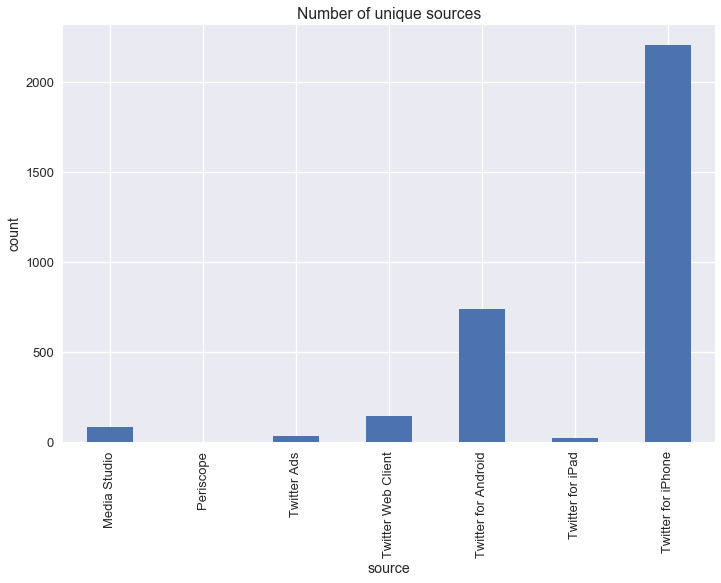

In [24]:
num_sources = len(trump['source'].unique())
num_sources

trump_2=trump.groupby('source').size()
trump_2
#make a bar plot here
trump_2.plot(kind='bar', title='Number of unique sources')
plt.xlabel("source")
plt.ylabel("count")
plt.show()

In [25]:
_ = ok.grade('q04a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/kRvAYx
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



As we can see from the plot above, Trump tweets are mostly from iPhone or Android. Is there a difference between his Tweet behavior between the two devices?

We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets):

In [26]:
print(trump_tweets[0]._json['created_at'])

Wed Oct 04 00:53:10 +0000 2017


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [27]:
trump['est_time'] = pd.Index(trump['time']).tz_localize("UTC").tz_convert("US/Eastern")
trump.head()

,time,source,text,retweet_count,est_time
ID,,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,My Administration will continue to work around...,3881,2017-10-03 20:53:10-04:00
915372999385198592,2017-10-04 00:28:24,Twitter for iPhone,RT @PressSec: .@POTUS and @FLOTUS meet w/ some...,2643,2017-10-03 20:28:24-04:00
915372694060830721,2017-10-04 00:27:11,Twitter for iPhone,RT @seanhannity: Tonight the truth about how d...,4364,2017-10-03 20:27:11-04:00
915372545704173570,2017-10-04 00:26:36,Twitter for iPhone,RT @IvankaTrump: 3/4: This Administration is d...,2297,2017-10-03 20:26:36-04:00
915372286575816705,2017-10-04 00:25:34,Twitter for iPhone,RT @billoreilly: FNC dominated ratings last ni...,3338,2017-10-03 20:25:34-04:00


---
<br/><br/>

## Question 4b

Use this data to make a line plot with two curves:

1. The number of iPhone tweets vs. hour of the day, normalized over the hours of the day. For example, if there were 10 tweets at 1pm and 20 tweets at 2pm, the line plot should be 0, then 0.33 at 1pm, 0.66 at 2pm, then back to 0.
2. The same curve for Android tweets.

Put the two curves in the same plot. You should get a plot that looks like:

![](device_hour.png)

Hint: use `value_counts` with `normalization`

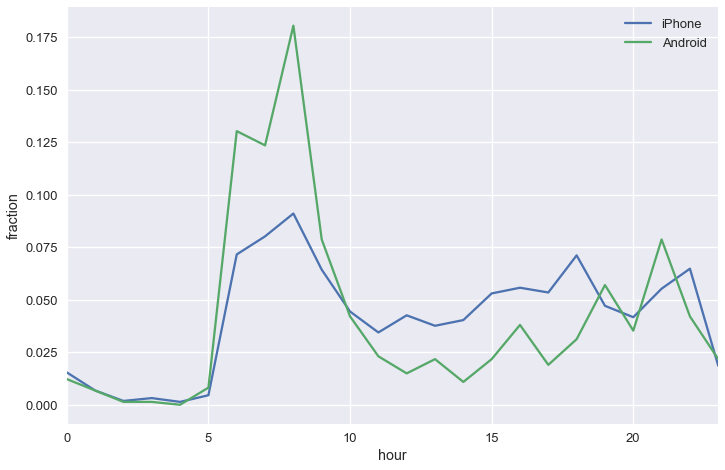

In [28]:
trump_3=trump[trump['source']=='Twitter for iPhone']
trump_4=trump_3.loc[:, 'est_time'].to_frame().reset_index()
trump_4
trump_4['hours']=trump_4['est_time'].dt.hour
trump_4
trump_5=trump_4['hours'].value_counts(normalize=True).to_frame()
trump_6=trump_5.reset_index()
trump_7=trump_6.sort_values(by='index')
trump_7
trump_8=trump_7.rename(columns={'index': 'hours', 'hours': 'iPhone'})
trump_8


trump_9=trump[trump['source']=='Twitter for Android']
trump_10=trump_9.loc[:, 'est_time'].to_frame().reset_index()
trump_10
trump_10['hours']=trump_10['est_time'].dt.hour
trump_10
trump_11=trump_10['hours'].value_counts(normalize=True).to_frame()
trump_12=trump_11.reset_index()
trump_13=trump_12.sort_values(by='index')
trump_14=trump_13.rename(columns={'index': 'hours', 'hours': 'Android'})
trump_14

trump_15=pd.merge(trump_8, trump_14, on="hours", how="left")
trump_16=trump_15.fillna(0)

plt.figure(figsize=(10, 7))

trump_16.plot('hours', ['iPhone', 'Android'])
plt.xlabel("hour")
plt.ylabel("fraction")

--- 
<br></br>

## Question 4c
What can you find out in the plot?

In [29]:
q4c_answer = r"""

-That Donald Trump tweets throughout the whole day. He seems to tweet a lot more with his Android before 10:00, and after that he tweets a more using his iPhone. 

-He tweets the most around 7:00-8:00.

"""

display(Markdown(q4c_answer))



-That Donald Trump tweets throughout the whole day. He seems to tweet a lot more with his Android before 10:00, and after that he tweets a more using his iPhone. 

-He tweets the most around 7:00-8:00.



--- 
<br></br>

Let's now look at his tweet device usage over the entire time period we have in the dataset.

Take a look at the code below and the plot it generates.

You should be answer the following questions about this code. You don't have to write the answers down anywhere, but you'll need to make variations of this plot in later questions so understanding this code will help you greatly.

1. What does `set_index` do here?
1. What does `resample` do? What does the `'D'` argument do in `resample`?
1. What does `unstack` do? What does the `level=0` argument do in unstack?
1. Why does one call to `plot()` generate 7 lines?

Feel free to copy this cell, play around with the code to see the intermediate result, then delete your cell after you're done.

(**Also, all the questions in this project can be answered using this style of method chaining.** If you write `for` loops in this project, know that there is a better way.)

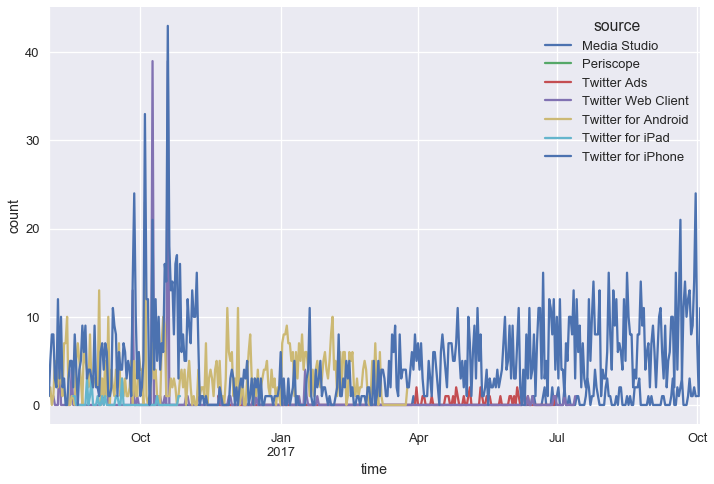

In [30]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('D')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')

## Question 4d

One problem with the plot above is that it plots too many points to see overall trends in the device usage.

Recreate the plot above, grouping by each month instead of each day. You may want to use the `figsize` argument to `plot` to make your plot larger.

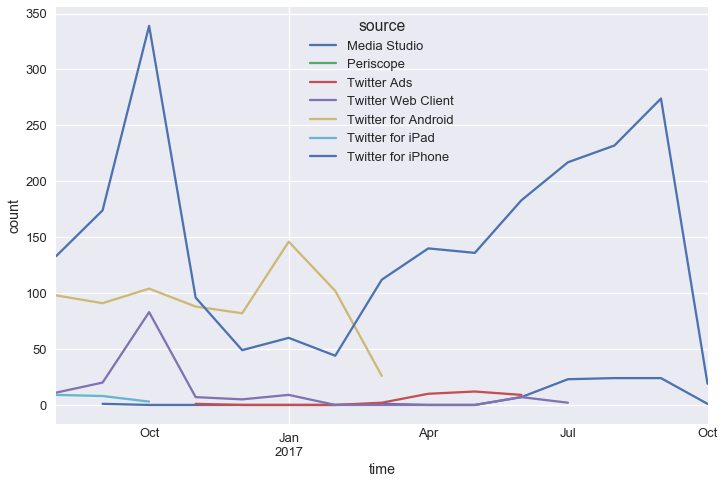

In [31]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')

According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Does the data support the information in the article? What else do you find out about changes in Trump's tweets sources from the plot?

In [32]:
q4d_answer = r"""

-Yes, the data support the information in the article. The plot clearly shows that Trump was still using his Android after his inauguration. 

-The plot also shows that since around March Trump hasn't used his Android anymore. 

-Trump barely uses the other sources to tweet, there is not a pattern of when he uses them.

"""

display(Markdown(q4d_answer))



-Yes, the data support the information in the article. The plot clearly shows that Trump was still using his Android after his inauguration. 

-The plot also shows that since around March Trump hasn't used his Android anymore. 

-Trump barely uses the other sources to tweet, there is not a pattern of when he uses them.



What are some ways we can distinguish between tweets that came from Trump and tweets from his staff? Before, it was as easy as checked which device the tweet came from. Now, we have to rely on more sophisticated methods.

## Project Checkpoint Reached

Congrats, you just reached the Project 1 checkpoint!

Now, run the cell below to submit your assignment to OkPy. The autograder should email you shortly with your autograded score. The autograder will only run once every 30 minutes.

Note that you'll probably get 0 points on Questions 5-8. Since you haven't gotten there yet, don't worry about missing those points.

**Note that the checkpoint is graded on completeness. This means that we'll check whether you attempted to solve each question, not whether you've gotten them right. When you submit the final submission of the project, you can go back and revise your answers to Questions 1-4.**

In [ ]:
_ = ok.submit()

---
<br></br>

## Question 5: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [33]:
!head vader_lexicon.txt

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]


---
<br/><br/>

## Question 5a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [35]:
table=pd.read_table('vader_lexicon.txt', names=["token", "polarity", "End", "Coverage"])
table
table_1= table.loc[:,['token', 'polarity']]
sent= table_1.set_index('token')
sent

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7
( '}{' ),1.6
(%,-0.9
('-:,2.2
(':,2.3


In [36]:
_ = ok.grade('q05a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/2kZY3P
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/><br/>

## Question 5b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [37]:
trump['text']=trump['text'].str.lower().to_frame()
trump

,time,source,text,retweet_count,est_time
ID,,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,my administration will continue to work around...,3881,2017-10-03 20:53:10-04:00
915372999385198592,2017-10-04 00:28:24,Twitter for iPhone,rt @presssec: .@potus and @flotus meet w/ some...,2643,2017-10-03 20:28:24-04:00
915372694060830721,2017-10-04 00:27:11,Twitter for iPhone,rt @seanhannity: tonight the truth about how d...,4364,2017-10-03 20:27:11-04:00
915372545704173570,2017-10-04 00:26:36,Twitter for iPhone,rt @ivankatrump: 3/4: this administration is d...,2297,2017-10-03 20:26:36-04:00
915372286575816705,2017-10-04 00:25:34,Twitter for iPhone,rt @billoreilly: fnc dominated ratings last ni...,3338,2017-10-03 20:25:34-04:00
915371898774618112,2017-10-04 00:24:02,Twitter for iPhone,rt @jenniffer2012: thank you @realdonaldtrump ...,4940,2017-10-03 20:24:02-04:00
915371086249971712,2017-10-04 00:20:48,Twitter for iPhone,"it is a ""miracle"" how fast the las vegas metro...",6394,2017-10-03 20:20:48-04:00
915351470354108417,2017-10-03 23:02:51,Twitter for iPhone,"so proud of @fema, military, and first respond...",6426,2017-10-03 19:02:51-04:00
915335645719121920,2017-10-03 21:59:58,Twitter for iPhone,great meeting with governor mapp of the #usvi....,4514,2017-10-03 17:59:58-04:00


In [38]:
_ = ok.grade('q05b')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/0RZW1G
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/><br/>

## Question 5c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [39]:
# Save your regex in punct_re
punct_re = r"[^\w\s]"
trump['no_punc'] = trump['text'].str.replace(punct_re, " ")
trump

,time,source,text,retweet_count,est_time,no_punc
ID,,,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,my administration will continue to work around...,3881,2017-10-03 20:53:10-04:00,my administration will continue to work around...
915372999385198592,2017-10-04 00:28:24,Twitter for iPhone,rt @presssec: .@potus and @flotus meet w/ some...,2643,2017-10-03 20:28:24-04:00,rt presssec potus and flotus meet w some...
915372694060830721,2017-10-04 00:27:11,Twitter for iPhone,rt @seanhannity: tonight the truth about how d...,4364,2017-10-03 20:27:11-04:00,rt seanhannity tonight the truth about how d...
915372545704173570,2017-10-04 00:26:36,Twitter for iPhone,rt @ivankatrump: 3/4: this administration is d...,2297,2017-10-03 20:26:36-04:00,rt ivankatrump 3 4 this administration is d...
915372286575816705,2017-10-04 00:25:34,Twitter for iPhone,rt @billoreilly: fnc dominated ratings last ni...,3338,2017-10-03 20:25:34-04:00,rt billoreilly fnc dominated ratings last ni...
915371898774618112,2017-10-04 00:24:02,Twitter for iPhone,rt @jenniffer2012: thank you @realdonaldtrump ...,4940,2017-10-03 20:24:02-04:00,rt jenniffer2012 thank you realdonaldtrump ...
915371086249971712,2017-10-04 00:20:48,Twitter for iPhone,"it is a ""miracle"" how fast the las vegas metro...",6394,2017-10-03 20:20:48-04:00,it is a miracle how fast the las vegas metro...
915351470354108417,2017-10-03 23:02:51,Twitter for iPhone,"so proud of @fema, military, and first respond...",6426,2017-10-03 19:02:51-04:00,so proud of fema military and first respond...
915335645719121920,2017-10-03 21:59:58,Twitter for iPhone,great meeting with governor mapp of the #usvi....,4514,2017-10-03 17:59:58-04:00,great meeting with governor mapp of the usvi ...


In [40]:
_ = ok.grade('q05c')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/mZxDAA
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>

## Question 5d:


Now, let's convert the tweets into what's called a *tidy format* to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>907698529606541312</th>
      <td>0</td>
      <td>it</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>1</td>
      <td>was</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>2</td>
      <td>a</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>3</td>
      <td>great</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>4</td>
      <td>honor</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `907698529606541312` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

This will require some rather advanced Pandas hacking, but our solution uses a chain of 5 methods on the `trump` DF.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.


In [41]:
tidy_format = (trump['no_punc'].str.split(expand=True)
 .stack()
 .reset_index()
 .rename(columns={'ID': '', 'level_1': 'num', 0:'word'})
 .set_index('')
 #.to_frame()
 #.groupby('source')
 #.resample('D')
 #.size()
 #.unstack(level=0)
 #.plot()
)


tidy_format

,num,word
,,
915379231454003200,0,my
915379231454003200,1,administration
915379231454003200,2,will
915379231454003200,3,continue
915379231454003200,4,to
915379231454003200,5,work
915379231454003200,6,around
915379231454003200,7,the
915379231454003200,8,clock


In [42]:
_ = ok.grade('q05d')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/wpLQPm
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>


## Question 5e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. Calculate a table called `polarities`. Its index should be the IDs of the tweets (one row per ID). It should have one column called `polarity` containing the summed sentiment polarity of each tweet.

Here are the first couple rows of our table. Again, you may have different tweet IDs depending on when you downloaded the tweets, but make sure the format looks the same.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>polarity</th>
    </tr>
    <tr>
      <th>index</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>755486029742641152</th>
      <td>0.0</td>
    </tr>
    <tr>
      <th>755502053003190273</th>
      <td>0.0</td>
    </tr>
    <tr>
      <th>755525857456844800</th>
      <td>2.2</td>
    </tr>
    <tr>
      <th>755551039244341253</th>
      <td>6.7</td>
    </tr>
    <tr>
      <th>755708398537154560</th>
      <td>7.6</td>
    </tr>
  </tbody>
</table>

In [43]:
sent_2=sent.reset_index()
tidy_format_2=tidy_format.reset_index()
polarities = (pd.merge(tidy_format_2, sent_2, left_on = 'word', right_on = 'token', how="left")
             .fillna(0)
             .loc[:, ["", 'polarity']]
             .groupby("")
             .sum()
             .reset_index()
             .rename(columns={'': 'index', 'polarity': 'polarity'})
             .set_index('index')
             )
polarities

,polarity
index,
760594155835887616,2.2
760669268539301889,5.7
760765818917515264,8.1
760783130978648064,-4.0
760888078605090821,1.2
760957697579708416,1.5
760960985524043777,4.3
760976212068106240,3.2
761025834350018561,1.5


In [44]:
_ = ok.grade('q05e')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/G6mBGQ
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>


## Question 5f:

Finally, use the `polarities` and `trump` tables to create a new table called `senti` that is the `trump` table with an extra column called `polarity` containing the sentiment polarity of each tweet.

In [45]:
polarities_2=polarities.reset_index()
trump_2=trump.reset_index()
trump_2
senti = (pd.merge(trump_2, polarities_2, left_on = 'ID', right_on = 'index', how="left") 
                .loc[:, ['ID', 'time', 'source', 'text', 'retweet_count', 'est_time', 'no_punc', 'polarity']]
                .set_index('ID'))
senti

,time,source,text,retweet_count,est_time,no_punc,polarity
ID,,,,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,my administration will continue to work around...,3881,2017-10-03 20:53:10-04:00,my administration will continue to work around...,4.9
915372999385198592,2017-10-04 00:28:24,Twitter for iPhone,rt @presssec: .@potus and @flotus meet w/ some...,2643,2017-10-03 20:28:24-04:00,rt presssec potus and flotus meet w some...,0.0
915372694060830721,2017-10-04 00:27:11,Twitter for iPhone,rt @seanhannity: tonight the truth about how d...,4364,2017-10-03 20:27:11-04:00,rt seanhannity tonight the truth about how d...,1.3
915372545704173570,2017-10-04 00:26:36,Twitter for iPhone,rt @ivankatrump: 3/4: this administration is d...,2297,2017-10-03 20:26:36-04:00,rt ivankatrump 3 4 this administration is d...,4.3
915372286575816705,2017-10-04 00:25:34,Twitter for iPhone,rt @billoreilly: fnc dominated ratings last ni...,3338,2017-10-03 20:25:34-04:00,rt billoreilly fnc dominated ratings last ni...,-0.8
915371898774618112,2017-10-04 00:24:02,Twitter for iPhone,rt @jenniffer2012: thank you @realdonaldtrump ...,4940,2017-10-03 20:24:02-04:00,rt jenniffer2012 thank you realdonaldtrump ...,9.9
915371086249971712,2017-10-04 00:20:48,Twitter for iPhone,"it is a ""miracle"" how fast the las vegas metro...",6394,2017-10-03 20:20:48-04:00,it is a miracle how fast the las vegas metro...,-1.8
915351470354108417,2017-10-03 23:02:51,Twitter for iPhone,"so proud of @fema, military, and first respond...",6426,2017-10-03 19:02:51-04:00,so proud of fema military and first respond...,3.6
915335645719121920,2017-10-03 21:59:58,Twitter for iPhone,great meeting with governor mapp of the #usvi....,4514,2017-10-03 17:59:58-04:00,great meeting with governor mapp of the usvi ...,8.9


In [46]:
_ = ok.grade('q05f')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/R6AQW0
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [47]:
print('Most negative tweets:')
for t in senti.sort_values('polarity').head()['text']:
    print('  ', t)

Most negative tweets:
   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.
   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no
   rt @seanspicer: .@timkaine wants to tough on crime - fails to talk about defending rapists and murders #vpdebate
   the fake news media has never been so wrong or so dirty. purposely incorrect stories and phony sources to meet their agenda of hate. sad!
   the failing new york times foiled u.s. attempt to kill the single most wanted terrorist,al-baghdadi.their sick agenda over national security


In [48]:
print('Most positive tweets:')
for t in senti.sort_values('polarity', ascending=False).head()['text']:
    print('  ', t)

Most positive tweets:
   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine
   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…
   "@pauladuvall2: we're all enjoying you, as well, mr. t.! you've inspired hope and a positive spirit throughout america! god bless you!" nice
   great honor to be endorsed by popular &amp; successful @gov_gilmore of va. a state that i very much want to win-thx jim! https://t.co/x4y1tafhvn
   hope you like my nomination of judge neil gorsuch for the united states supreme court. he is a good and brilliant man, respected by all.


---
<br></br>

## Question 5g

Use seaborn to create a `distplot` of the sentiments. What do you notice? (You don't have to write this down in the notebook.)

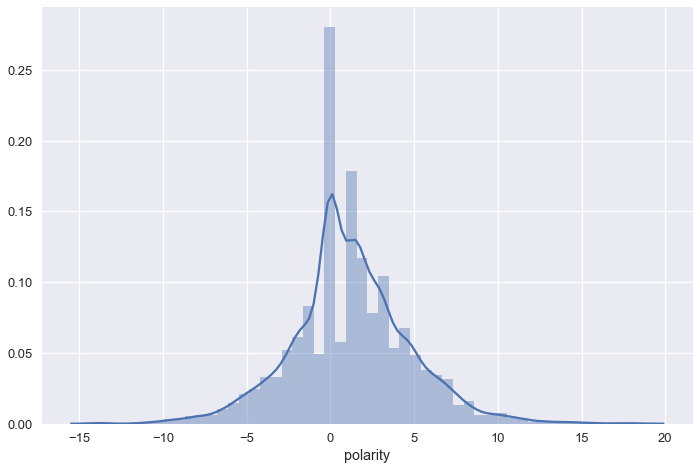

In [49]:
sns.distplot(senti['polarity'])

---
<br></br>

## Question 5h
Create a line plot of the sentiment of Trump's tweets over time. Plot the mean sentiment of each month of his tweets over time. Then, plot vertical lines corresponding to his election and inauguration dates. Your final plot should look like:

![](senti_time.png)

Then, describe what you notice and save your result in the variable `senti_time_answer`.

/Users/leongutierrez/anaconda3/envs/ds100/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.




From the plot I can see that the polarity in Trump's reaches it's maximum positive sentiment when he wins the election, but right after, it starts decreasing. Because of his win, some people were not happy about it, and started protesting. As a result, Trump tweets had a not so possitive sentiment. He attacked all these people who opposed him with his tweets. The polarity of his tweeted currently is reaching its maximum sentiment because of his positive words for all those people affected by either natural disasters or violence.   



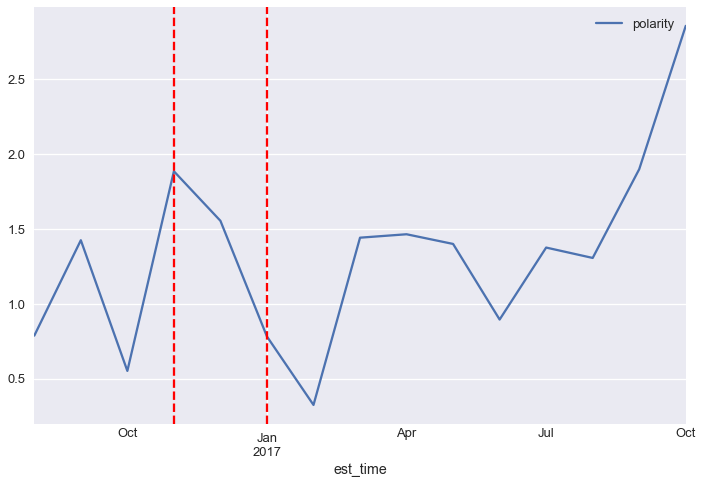

In [50]:
# Create your plot here...
(senti.loc[:, ['est_time', 'polarity']]
 .set_index('est_time')
 .resample('M')
.plot()
)
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
plt.axvline(ELEC_DATE, color='r', linestyle='--' )
plt.axvline(INAUG_DATE, color='r', linestyle='--')


# ...then write your takeaways here.
senti_time_answer = '''

From the plot I can see that the polarity in Trump's reaches it's maximum positive sentiment when he wins the election, but right after, it starts decreasing. Because of his win, some people were not happy about it, and started protesting. As a result, Trump tweets had a not so possitive sentiment. He attacked all these people who opposed him with his tweets. The polarity of his tweeted currently is reaching its maximum sentiment because of his positive words for all those people affected by either natural disasters or violence.   

'''
display(Markdown(senti_time_answer))

## Question 6: Hashtags

Let's return now to the problem of determining which tweets were from Trump and which were from his aides. As a reminder, most analysts agree that tweets that came from an Android device were likely from Trump himself, not one of his aides ([example](http://didtrumptweetit.com/machine-learning-tweet-prediction/)).

In addition, browsing his Twitter shows that some tweets that sound more "official" often have a hashtag, link, or a picture:

![](aide.png)

Whereas tweets that sound like Trump himself usually don't have a hashtag, link, or picture:

![](trump.png)

So, we can hypothesize that if a tweet has a hashtag, link, or picture it came from one of Trump's aides, not Trump himself. Let's see if this idea is backed up by the data.

---
<br></br>

## Question 6a

Create a DF called `hash_or_link` that contains only the rows from the `senti` table where the tweet isn't a retweet and contains a hashtag, link, or picture. We say that:

- A tweet is a retweet if it has the string 'rt' anywhere in the tweet if it is preceeded and followed by a non-word character (the start and end of the string count as non-word characters).
- A tweet has a hashtag if it has the character '#' anywhere in the tweet followed by a letter.
- A tweet contains a link or a picture if it has the word `http` anywhere in the tweet

(You can check out Trump's Twitter for why these criteria are true).

In [51]:
# You must save your regex for retweets in this variable
rt_re = r'^(rt)|(rt)$|[^a-zA-Z](rt)[^a-zA-Z]'
# You must save your regex for hashtags, links, or pictures in this variable
hash_re = r'#[a-zA-Z]|^(http)|(http)$|http'
hash_or_link = senti[senti['text'].str.contains(hash_re) & ~senti['text'].str.contains(rt_re)]  
hash_or_link

/Users/leongutierrez/anaconda3/envs/ds100/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


,time,source,text,retweet_count,est_time,no_punc,polarity
ID,,,,,,,
915379231454003200,2017-10-04 00:53:10,Twitter for iPhone,my administration will continue to work around...,3881,2017-10-03 20:53:10-04:00,my administration will continue to work around...,4.9
915351470354108417,2017-10-03 23:02:51,Twitter for iPhone,"so proud of @fema, military, and first respond...",6426,2017-10-03 19:02:51-04:00,so proud of fema military and first respond...,3.6
915335645719121920,2017-10-03 21:59:58,Twitter for iPhone,great meeting with governor mapp of the #usvi....,4514,2017-10-03 17:59:58-04:00,great meeting with governor mapp of the usvi ...,8.9
915326171063242752,2017-10-03 21:22:19,Twitter for iPhone,leaving puerto rico now for d.c. will be in la...,9371,2017-10-03 17:22:19-04:00,leaving puerto rico now for d c will be in la...,0.9
914661855947366406,2017-10-02 01:22:34,Media Studio,congratulations to #teamusa🇺🇸🏆on your great @p...,11614,2017-10-01 21:22:34-04:00,congratulations to teamusa on your great p...,6.0
914310901855129601,2017-10-01 02:08:00,Twitter for iPhone,"19,000 respecting our national anthem! #standf...",30747,2017-09-30 22:08:00-04:00,19 000 respecting our national anthem standf...,2.2
914260261304860672,2017-09-30 22:46:47,Media Studio,because of #fakenews my people are not getting...,31397,2017-09-30 18:46:47-04:00,because of fakenews my people are not getting...,4.7
914217477495717889,2017-09-30 19:56:46,Twitter for iPhone,@ricardorossello ......#fakenews critics are w...,7728,2017-09-30 15:56:46-04:00,ricardorossello fakenews critics are w...,3.9
914216744385904640,2017-09-30 19:53:51,Twitter for iPhone,to the people of puerto rico:\ndo not believe ...,15917,2017-09-30 15:53:51-04:00,to the people of puerto rico \ndo not believe ...,0.0


In [52]:
_ = ok.grade('q06a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/73ZglG
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



--- 
<br></br>

## Question 6b

Create a line plot of the number of tweets containing a hashtag, link, or picture from each tweet device.

If a device doesn't have at least 20 tweets in a particular year, don't include the tweets from that device for that year. (Eg. if there are 100 tweets from Twitter Ads in 2016 but only 10 in 2017, plot the counts for Twitter Ads in 2016 but not 2017.)

Aggregate the counts for each week period. Your final plot should look like:

![](hashtag_by_device.png)

*Hint:* If you can get a table in the following format, you can just call `.plot()` on it to generate the plot.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>source</th>
      <th>Media Studio</th>
      <th>Twitter Ads</th>
      <th>Twitter Web Client</th>
      <th>Twitter for Android</th>
      <th>Twitter for iPhone</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-24</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>4.0</td>
      <td>10.0</td>
      <td>14.0</td>
    </tr>
    <tr>
      <th>2016-08-07</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>5.0</td>
      <td>15.0</td>
      <td>91.0</td>
    </tr>
    <tr>
      <th>2016-08-21</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>9.0</td>
      <td>10.0</td>
      <td>44.0</td>
    </tr>
    <tr>
      <th>2016-09-04</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>0.0</td>
      <td>20.0</td>
      <td>51.0</td>
    </tr>
    <tr>
      <th>2016-09-18</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>1.0</td>
      <td>12.0</td>
      <td>59.0</td>
    </tr>
  </tbody>
</table>

What conclusions can you draw from this plot? Does this plot allow us to say whether a tweet containing a hashtag/link/picture likely came from Trump himself? Write your takeaways in `hashtag_answer` variable.

/Users/leongutierrez/anaconda3/envs/ds100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until





-Yes, that plot allows us to say that most of the tweets containing a hashtag, link, or picture come an iPhone, which proves the theory about Trump's staff posting tweets. The curve for the tweets coming from an iPhone has higher values since the beginning of the graph (during the campaign), and reaches its peak around the beginning of November, which is when Trump was elected as president of the U.S. There was an expectation from the media for Trump to sound more presidential, and his staff helped to to do so through his twitter account.  

-The article mentions how Trump tweets mostly with his Android, and in this plot, the Android curve ends right before Trump's inauguration, which shows that the tweets with a hashtag, link, or, picture don't belong to Trump himself. This plot with connection with the other article about Trump using his Android to tweets confirm the theory about his staff using his iPhone.   



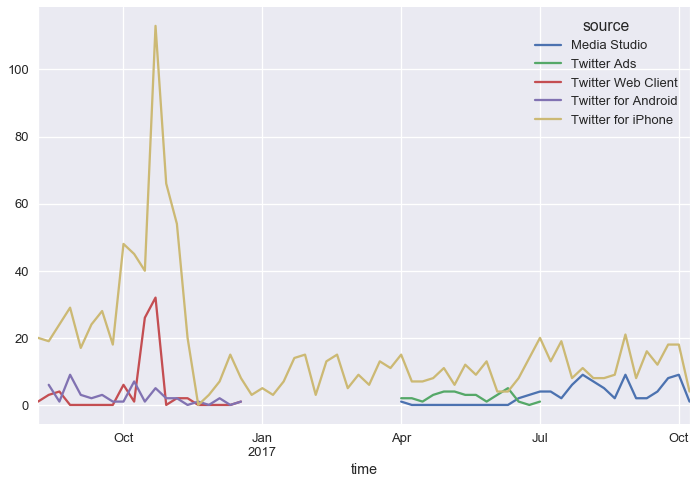

In [53]:
# Create your plot here...
tweets_2=hash_or_link
tweets_2['year']=tweets_2['time'].dt.year
tweets_3=tweets_2.groupby(['source', 'year']).size().reset_index(name='count')
tweets_4=tweets_3[tweets_3['count']>20]
tweets_4

hi=pd.merge(hash_or_link, tweets_4, on=['source', 'year'], how='inner')
hi

hi_2=(hi.loc[:, ['time', 'source']]
 .set_index('time')
 .groupby('source')
 .resample('W')
 .size()
 .unstack(level=0)
 .plot()
)
hi_2

#...then write your takeaways here.
hashtag_answer = '''


-Yes, that plot allows us to say that most of the tweets containing a hashtag, link, or picture come an iPhone, which proves the theory about Trump's staff posting tweets. The curve for the tweets coming from an iPhone has higher values since the beginning of the graph (during the campaign), and reaches its peak around the beginning of November, which is when Trump was elected as president of the U.S. There was an expectation from the media for Trump to sound more presidential, and his staff helped to to do so through his twitter account.  

-The article mentions how Trump tweets mostly with his Android, and in this plot, the Android curve ends right before Trump's inauguration, which shows that the tweets with a hashtag, link, or, picture don't belong to Trump himself. This plot with connection with the other article about Trump using his Android to tweets confirm the theory about his staff using his iPhone.   

'''
display(Markdown(hashtag_answer))

--- 
<br></br>

## Question 6c 

Now, let's see whether there's a difference in sentiment for tweets with hashtags and those without.

Create a line plot of the sentiment of Trump's non-retweet tweets over time, taking the mean sentiment for every month. Plot one line for tweets with hashtags and one for tweets without. Then, draw two vertical lines for the election date and inauguration date. Draw a horizontal line for y=0. Your plot should look like:

![](hash_senti.png)

What do you notice about the plot? What conclusions can you draw? Write your answers in `hash_senti_answer`.

Hint 1: You'll want to start use your `senti` table, not your `hash_or_link` table. Try adding a column to `senti` containing True if the tweet has a hashtag/link/picture.

Hint 2: You shouldn't use your `no_punc` column. Think about why not.

/Users/leongutierrez/anaconda3/envs/ds100/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  




I notice that those tweets with hashtags have a higher polarity, than those without. Taking into account the other plot, and this one we can conclude that the tweets with hashtags, links, and pictures are posted by his staff. The curve of the tweets with no hashtags has negative polarity, which exemplifies some of the negative sentiment in Trump's tweets. `   



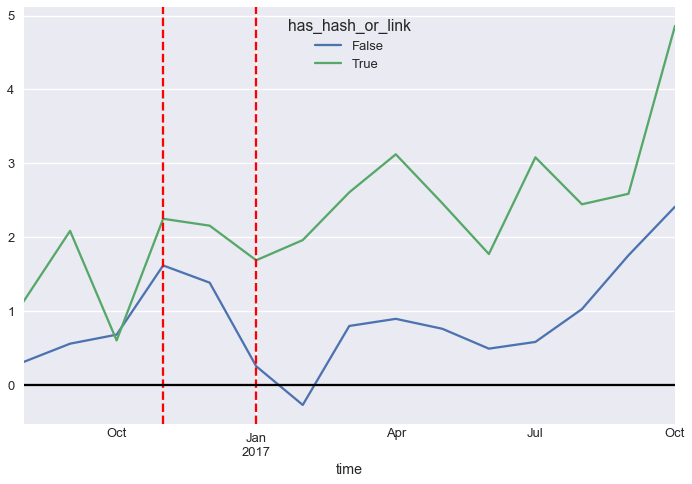

In [54]:
# Create your plot here...
senti['has_hash_or_link']=senti['text'].str.contains(hash_re)[~senti['text'].str.contains(rt_re)]
sabe=(senti.loc[:, ['est_time', 'has_hash_or_link', 'polarity']]
 .set_index('est_time')
 .groupby('has_hash_or_link')
 .resample('M')
 .mean()
 .unstack(level=0)
 .loc[:, 'polarity']
 .plot()
)
plt.axvline(ELEC_DATE, color='r', linestyle='--' )
plt.axvline(INAUG_DATE, color='r', linestyle='--')
plt.axhline(0, color='black')
plt.xlabel('time')

sabe
#...then write your takeaways here.
hash_senti_answer = '''

I notice that those tweets with hashtags have a higher polarity, than those without. Taking into account the other plot, and this one we can conclude that the tweets with hashtags, links, and pictures are posted by his staff. The curve of the tweets with no hashtags has negative polarity, which exemplifies some of the negative sentiment in Trump's tweets. `   

'''
display(Markdown(hash_senti_answer))

--- 

## Question 7: Engagement

---
<br></br>
## Question 7a

Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, find out the number of retweets that its tweet got. Filter out words that didn't appear in at least 25 tweets, find out the median number of retweets each word got, and save the top 20 most retweeted words into a DataFrame called `top_20`. Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fake</th>
      <td>22963.0</td>
    </tr>
    <tr>
      <th>news</th>
      <td>20463.0</td>
    </tr>
    <tr>
      <th>ds100</th>
      <td>20432.0</td>
    </tr>
    <tr>
      <th>great</th>
      <td>20159.0</td>
    </tr>
    <tr>
      <th>class</th>
      <td>20121.0</td>
    </tr>
  </tbody>
</table>

In [55]:
tidy_format_2=tidy_format.reset_index()
top_20_1=(pd.merge(tidy_format_2, trump_2, left_on = '', right_on = 'ID', how="left")
          .loc[:, ['ID', 'word', 'retweet_count']]
          .groupby('word')
          .size()
          .reset_index(name='count')
         )
top_20_1
top_20_2=top_20_1[top_20_1['count']>=25]
top_20_3=(pd.merge(tidy_format_2, trump_2, left_on = '', right_on = 'ID', how="left")
          .loc[:, ['ID', 'word', 'retweet_count']]
            )
top_20=(pd.merge(top_20_3, top_20_2, left_on = 'word', right_on = 'word', how="right")
          .loc[:, ['word', 'retweet_count']]
          .groupby('word')
          .median()
          .sort_values(ascending=False, by='retweet_count')
          .head(20)
        )
top_20

,retweet_count
word,
fake,22120.0
russia,21217.0
should,20946.5
korea,20797.0
news,20396.0
sad,20288.5
story,20097.0
nothing,20070.0
russian,20015.0


In [56]:
_ = ok.grade('q07a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Backup... 100% complete
Backup successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/backups/qxBKPR
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Here's a bar chart of your results:

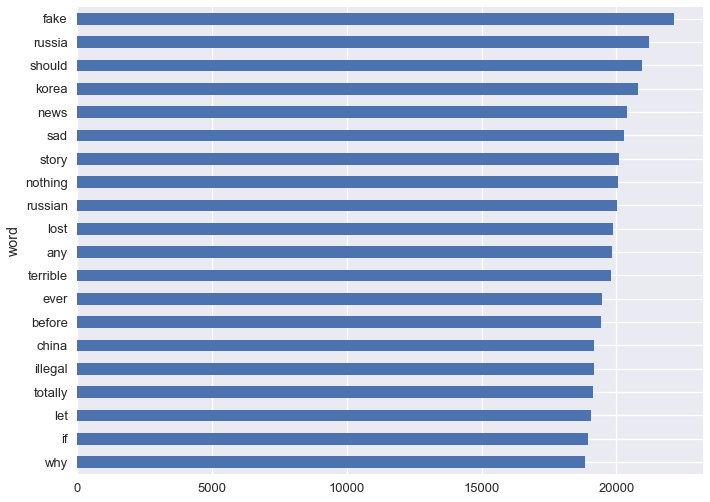

In [57]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8))

---
<br></br>

## Question 7b

The phrase "fake news" is apparently really popular! We can conclude that Trump's tweets containing "fake" and/or "news" result in the most retweets relative to words his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made "fake" and/or "news" higher on our list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

In [71]:
engagement_answer = '''

1. True, restricting our word list to nounce would increase the position of "news" because the word "should" wouldn't show up on our list anymore. However, it would remove "fake" from our list, since it is an adjetive. 


2. False, We never removed hashtags, so regex would count them as different words, so it wouldn't change the position of "fake" and "news".


3. True, the fact that Trump's follower count has increased over time makes each tweet to be retweeted it more times, and consecuently changes the position of the words. However, it is likely it will improve the standings of both words, especially "fake". People seem to be intrigued by these two words, so everytime "fake" and/or "news" appears on one of Trump's tweets, followers tend to retweet them. These words create makes followers to engage in a debate to support Trump's opinion about the news, or to contradict it.     

'''
display(Markdown(engagement_answer))



1. True, restricting our word list to nounce would increase the position of "news" because the word "should" wouldn't show up on our list anymore. However, it would remove "fake" from our list, since it is an adjetive. 


2. False, We never removed hashtags, so regex would count them as different words, so it wouldn't change the position of "fake" and "news".


3. True, the fact that Trump's follower count has increased over time makes each tweet to be retweeted it more times, and consecuently changes the position of the words. However, it is likely it will improve the standings of both words, especially "fake". People seem to be intrigued by these two words, so everytime "fake" and/or "news" appears on one of Trump's tweets, followers tend to retweet them. These words create makes followers to engage in a debate to support Trump's opinion about the news, or to contradict it.     



---
## Question 8: Fake News

---
<br></br>
## Question 8a 

Let's investigate the term "fake news" a bit more. Create a table called `fake_counts` that has two columns:

1. `fake_news`: The number of tweets containing the term "fake news".
1. `total`: The total number of tweets for the time period.

The index of the table should be datetimes for each two-week period in the data.

The resulting table should look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fake_news</th>
      <th>total</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-31</th>
      <td>0</td>
      <td>79</td>
    </tr>
    <tr>
      <th>2016-08-14</th>
      <td>0</td>
      <td>143</td>
    </tr>
    <tr>
      <th>2016-08-28</th>
      <td>0</td>
      <td>118</td>
    </tr>
    <tr>
      <th>2016-09-11</th>
      <td>0</td>
      <td>121</td>
    </tr>
    <tr>
      <th>2016-09-25</th>
      <td>0</td>
      <td>111</td>
    </tr>
  </tbody>
</table>

In [137]:
fake_news_re=r'fake news'
fake_counts_2=trump_2.loc[:, ['ID', 'time', 'text']]
fake_counts_2['fake_news']=fake_counts_2['text'].str.contains(fake_news_re)
fake_counts_3=(fake_counts_2.loc[:, ['time', 'ID', 'fake_news']]
              .set_index('time')
              .resample('2W')
              .count()
              .reset_index()
              )
fake_counts_4=fake_counts_3.loc[:, ['time', 'ID']]
fake_counts_5=fake_counts_4.rename(columns={'time': 'time', 'ID': 'total'})
fake_counts_5

fake_counts_6=(fake_counts_2.loc[:, ['time', 'ID', 'fake_news']]
              .set_index('time')
              .resample('2W')
              .sum()
              .reset_index()
             )
fake_counts_6

fake_counts_6['total']=fake_counts_5['total']
fake_counts_6['fake_news']=fake_counts_6['fake_news'].astype(int)
fake_counts_6['total']=fake_counts_6['total'].astype(int)
fake_counts=fake_counts_6.set_index('time')
fake_counts


,fake_news,total
time,,
2016-08-07,0,39
2016-08-21,0,112
2016-09-04,0,131
2016-09-18,0,127
2016-10-02,0,147
2016-10-16,0,237
2016-10-30,0,273
2016-11-13,0,126
2016-11-27,0,48


In [138]:
_ = ok.grade('q08a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: leonrafael29@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/wpLO5r
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



--- 
<br></br>

## Question 8b

Now, create a line plot showing the proportion of tweets containing the term "fake news" over time. Then, draw two vertical lines corresponding to the election and inauguration dates.

What do you notice? Write your conclusions in `fake_news_answer`.



I notice that Trump started tweeting about 'fake news' right after his inauguration since that is the time when the media was reporting about the possibility of connections between Trump and Russia during the election. Since then, he hasn't stopped twitting about it.  



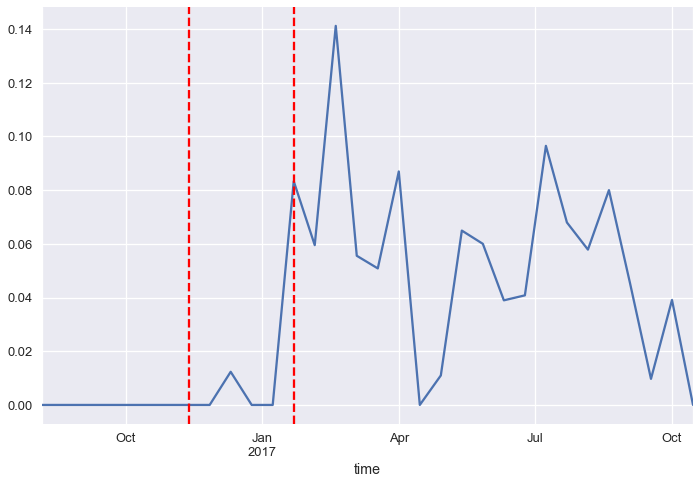

In [139]:
fake_counts_7=fake_counts
fake_counts_7['proportion']=fake_counts['fake_news']/fake_counts['total']
fake_counts_8=(fake_counts_7.loc[:,'proportion']
     .plot())
plt.axvline(ELEC_DATE, color='r', linestyle='--' )
plt.axvline(INAUG_DATE, color='r', linestyle='--')
plt.xlabel('time')

fake_counts_8
# ...then write your takeaways here.
fake_news_answer = '''

I notice that Trump started tweeting about 'fake news' right after his inauguration since that is the time when the media was reporting about the possibility of connections between Trump and Russia during the election. Since then, he hasn't stopped twitting about it.  

'''
display(Markdown(fake_news_answer))

## Submission

Congrats, you just finished Project 1!

Run the cell below to run all the OkPy tests at once:

In [136]:
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("ok_tests") if q.startswith('q')]

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

Now, run the cell below to submit your assignment to OkPy. The autograder should email you shortly with your autograded score. The autograder will only run once every 30 minutes.

**If you're failing tests on the autograder but pass them locally**, you should simulate the autograder by doing the following:

1. In the top menu, click Kernel -> Restart and Run all.
2. Run the cell above to run each OkPy test.

**You must make sure that you pass all the tests when running steps 1 and 2 in order.** If you are still failing autograder tests, you should double check your results.

In [ ]:
_ = ok.submit()

<IPython.core.display.Javascript object>